In [1]:
import os 
os.chdir("../..")
import numpy
import numpy as np
import pandas as pd
import datetime
from scripts.PdfParse import *
from scripts.SupportFunc import *
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random

In [2]:
tonga_folder = os.getcwd() + "/data/tourism/tonga/temp/"
tonga_files = os.listdir(tonga_folder)
filepaths = [tonga_folder + file for file in tonga_files]

## Tonga Official Statistics
### 2019 and Later

In [3]:
monthly_temp_file_path = os.getcwd() + "/data/tourism/tonga/tonga_monthly_visitor.csv"
tonga = (pd.read_csv(monthly_temp_file_path)
         .drop("Unnamed: 0", axis=1))

# Subset the df by only including dates later than 2019
tonga_monthly_aft19 = (tonga[tonga.Year >= 2019]
                       .drop_duplicates()
                       .reset_index()
                       .drop(["Period", "index"], axis=1)
                       .sort_values(by="time", ascending=True)
                       .fillna(0))

In [4]:
# Check whether Total = the sum of (Air, Yacht, Ship)
error_dict = {}
for idx in tonga_monthly_aft19.index:
    cols = ["Air", "Ship", "Yacht"]
    row_sum = 0
    for col in cols:
        row_sum += tonga_monthly_aft19[col][idx]
    if row_sum == tonga_monthly_aft19["Total"][idx]:
        pass
    else:
        error_dict.update({tonga_monthly_aft19["time"][idx]: idx})

# Produce the duplicated entries
dupl_lst = tonga_monthly_aft19[tonga_monthly_aft19["time"].duplicated()
                               == True]["time"].to_list()

for date in dupl_lst:
    if date in error_dict.keys():
        tonga_monthly = tonga_monthly_aft19.drop(error_dict[date])
        error_dict.pop(date)
        dupl_lst.remove(date)

In [5]:
tonga_monthly_max = (tonga_monthly_aft19[["time", "Total"]]
                     .drop_duplicates()
                     .reset_index()
                     .drop("index", axis=1))

tonga_monthly_min = tonga_monthly_max.copy()


for date in dupl_lst:
    dupl_total = tonga_monthly_max[tonga_monthly_max.time == date]["Total"]
    if len(dupl_total) > 1:
        min_num, max_num = dupl_total.min(), dupl_total.max()
        min_idx = tonga_monthly_max[tonga_monthly_max.Total == min_num].index
        max_idx = tonga_monthly_min[tonga_monthly_min.Total == max_num].index
        tonga_monthly_max = tonga_monthly_max.drop(min_idx[0], axis=0)
        tonga_monthly_min = tonga_monthly_min.drop(max_idx[0], axis=0)


# Change the datetime format for tonga_monthly_min, tonga_monthly_max
tonga_monthly_max = tonga_monthly_max.reset_index().drop("index", axis=1)
tonga_monthly_min = tonga_monthly_min.reset_index().drop("index", axis=1)


tonga_monthly_max["time"], tonga_monthly_min["time"] = \
    pd.to_datetime(tonga_monthly_max["time"]), pd.to_datetime(
        tonga_monthly_min["time"])


tonga_monthly_max["Year"], tonga_monthly_max["Month"] = \
    tonga_monthly_max["time"].dt.year, tonga_monthly_max["time"].dt.month

tonga_monthly_min["Year"], tonga_monthly_min["Month"] = \
    tonga_monthly_min["time"].dt.year, tonga_monthly_min["time"].dt.month

In [6]:
tonga_monthly_max

,time,Total,Year,Month
0,2019-01-01,4688,2019,1
1,2019-02-01,6157,2019,2
2,2019-03-01,8686,2019,3
3,2019-04-01,7704,2019,4
4,2019-05-01,6800,2019,5
5,2019-06-01,8934,2019,6
6,2019-07-01,8315,2019,7
7,2019-08-01,8178,2019,8
8,2019-09-01,7829,2019,9
9,2019-10-01,8255,2019,10


In [7]:
tonga = (pd.read_csv(monthly_temp_file_path)
         .drop("Unnamed: 0", axis=1))

tonga_monthly_pre19 = (tonga[tonga.Year < 2019]
                       .drop_duplicates()
                       .sort_values(by="time", ascending=True)
                       .dropna()
                       .reset_index()
                       .drop(["index", "Period"], axis=1))

print(check_quality(tonga_monthly_pre19, ["time", "Year"], "Total"))

tonga_monthly_pre19 = (tonga_monthly_pre19.drop(index=96)
                       .reset_index()
                       .drop("index", axis=1))
tonga_monthly_pre19.groupby(by="Year").count()

[96]


,Air,Ship,Yacht,Total,time
Year,,,,,
2010,12,12,12,12,12
2011,11,11,11,11,11
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,13,13,13,13,13
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


## Aviation Data
### Correlation Analysis
#### Using Maximum for duplicated rows

In [8]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)
aviation.head(5)

,Country,ISO,Region,Date,Aircraft_type,Seats_arrivals_domestic,Seats_arrivals_interregional,Seats_arrivals_intraregional,Seats_arrivals_intl,Seats_arrivals_total,Available_seat_kilometers,Number_of_flights_domestic,Number_of_flights_interregional,Number_of_flights_intraregional,Number_of_flights_intl,Number_of_flights_total
0,Fiji,FJ,East Asia & Pacific,2019-01-01,passenger,839,273,3480,3753,4592,1.430416e+07,8,1,10,11,19
1,Fiji,FJ,East Asia & Pacific,2019-01-02,passenger,974,313,3471,3784,4758,1.495610e+07,8,1,10,11,19
2,Fiji,FJ,East Asia & Pacific,2019-01-03,passenger,1190,443,3675,4118,5308,1.592143e+07,10,2,12,14,24
3,Fiji,FJ,East Asia & Pacific,2019-01-04,passenger,831,586,3159,3745,4576,1.457334e+07,7,2,12,14,21
4,Fiji,FJ,East Asia & Pacific,2019-01-05,passenger,744,273,4752,5025,5769,1.773449e+07,7,1,12,13,20


In [9]:
tg_avi = (aviation[(aviation.ISO == "TO") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Number_of_flights_intl", "Number_of_flights_total",
            "Seats_arrivals_intl", "Seats_arrivals_total"]])

dates = pd.DataFrame(pd.date_range(start="2019-01-01",
                                   end="2021-12-31"), columns=["Date"])

tg_avi = dates.merge(tg_avi, how="left", on="Date")
tg_avi["Date"] = pd.to_datetime(tg_avi["Date"])
tg_avi["Month"], tg_avi["Year"] = tg_avi["Date"].dt.month, tg_avi["Date"].dt.year

tg_avi_19_21 = tg_avi.groupby(by=["Year", "Month"]).sum().reset_index()

In [10]:
tg_max_merged = tg_avi_19_21.merge(
    tonga_monthly_max, on=["Year", "Month"], how="left").drop("time", axis=1)


from scipy.stats import pearsonr


corr_seats_max, _ = pearsonr(tg_max_merged["Seats_arrivals_total"], tg_max_merged["Total"])
corr_seat_flight_max, _ = pearsonr(tg_max_merged["Number_of_flights_total"], tg_max_merged["Total"])
print(" Using the Maximum Values of the duplicated rows:  \n",
f"Pearson Correlation between FlightRadar's Seats Arrival and TG's census data is{corr_seats_max: .4f}. \n",
f"Pearson Correlation between FlightRadar's # of Flights Arrival and TG's census data is{corr_seat_flight_max: .4f}.")

# Correlation Matrix
cols = ["Seats_arrivals_intl", "Seats_arrivals_total",
        "Number_of_flights_total", "Number_of_flights_intl", "Total"]
corr_matrix_max = tg_max_merged[cols].corr()
corr_matrix_max

 Using the Maximum Values of the duplicated rows:  
 Pearson Correlation between FlightRadar's Seats Arrival and TG's census data is 0.9398. 
 Pearson Correlation between FlightRadar's # of Flights Arrival and TG's census data is 0.9521.


,Seats_arrivals_intl,Seats_arrivals_total,Number_of_flights_total,Number_of_flights_intl,Total
Seats_arrivals_intl,1.000000,0.995476,0.961636,0.986774,0.946237
Seats_arrivals_total,0.995476,1.000000,0.974741,0.981558,0.939756
Number_of_flights_total,0.961636,0.974741,1.000000,0.971579,0.952143
Number_of_flights_intl,0.986774,0.981558,0.971579,1.000000,0.956580
Total,0.946237,0.939756,0.952143,0.956580,1.000000


In [11]:
tg_min_merged = tg_avi_19_21.merge(
    tonga_monthly_min, on=["Year", "Month"], how="left").drop("time", axis=1)



corr_seats_min, _ = pearsonr(tg_min_merged["Seats_arrivals_total"], tg_min_merged["Total"])
corr_seat_flight_min, _ = pearsonr(tg_min_merged["Number_of_flights_total"], tg_min_merged["Total"])
print(" Using the Maximum Values of the duplicated rows:  \n",
f"Pearson Correlation between FlightRadar's Seats Arrival and TG's census data is{corr_seats_min: .4f}. \n",
f"Pearson Correlation between FlightRadar's # of Flights Arrival and TG's census data is{corr_seat_flight_min: .4f}.")

# Correlation Matrix
corr_matrix_min = tg_min_merged[cols].corr()
corr_matrix_min

 Using the Maximum Values of the duplicated rows:  
 Pearson Correlation between FlightRadar's Seats Arrival and TG's census data is 0.9401. 
 Pearson Correlation between FlightRadar's # of Flights Arrival and TG's census data is 0.9489.


,Seats_arrivals_intl,Seats_arrivals_total,Number_of_flights_total,Number_of_flights_intl,Total
Seats_arrivals_intl,1.000000,0.995476,0.961636,0.986774,0.944631
Seats_arrivals_total,0.995476,1.000000,0.974741,0.981558,0.940102
Number_of_flights_total,0.961636,0.974741,1.000000,0.971579,0.948930
Number_of_flights_intl,0.986774,0.981558,0.971579,1.000000,0.948709
Total,0.944631,0.940102,0.948930,0.948709,1.000000


### ADF test

In [12]:
test_result = pd.DataFrame()
for col in tg_max_merged.columns[2:]:
    col_result = adf_test(tg_max_merged[col])
    col_result_df = pd.DataFrame(col_result)
    col_result_df.columns = [col]
    test_result = pd.concat([test_result, col_result_df.T], axis=0)
    
test_result

Results of Dickey-Fuller Test:
Test Statistic                 -0.646765
p-value                         0.860061
# Lags Used                     1.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -2.115997
p-value                         0.238131
# Lags Used                     5.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -1.018914
p-value                         0.746303
# Lags Used                     5.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
R

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Number_of_flights_intl,-0.646765,0.860061,1.0,34.0,-3.639224,-2.951230,-2.614447
Number_of_flights_total,-2.115997,0.238131,5.0,30.0,-3.669920,-2.964071,-2.621171
Seats_arrivals_intl,-1.018914,0.746303,5.0,30.0,-3.669920,-2.964071,-2.621171
Seats_arrivals_total,-1.082484,0.722006,5.0,30.0,-3.669920,-2.964071,-2.621171
Total,-3.332505,0.013487,10.0,25.0,-3.723863,-2.986489,-2.632800


###  Grangers Causality

In [13]:
grangers_causation_matrix(tg_max_merged,
                          variables=["Total", "Seats_arrivals_total"],
                          maxlag=10)

,Total_x,Seats_arrivals_total_x
Total_y,1.0,0.0
Seats_arrivals_total_y,0.0,1.0


### Dynamic Time Wrapping

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

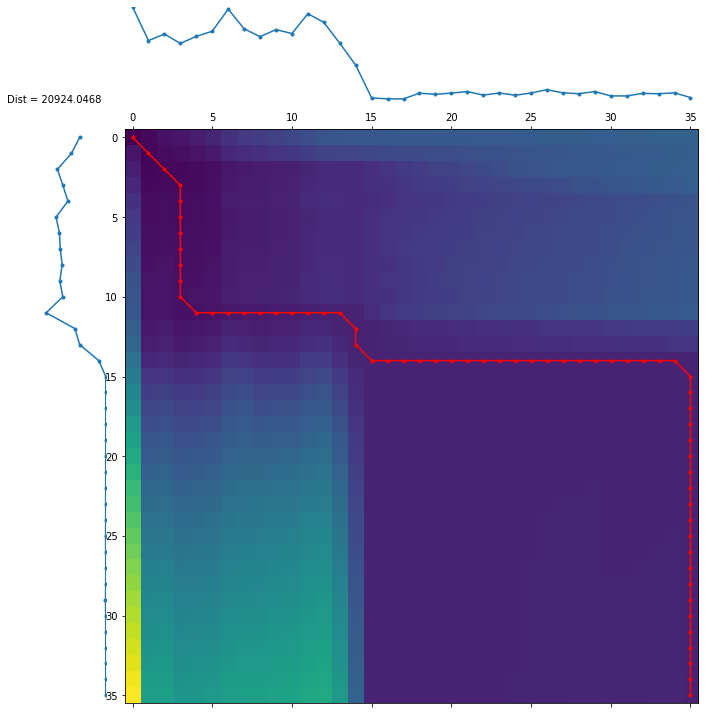

In [16]:
d, paths = dtw.warping_paths(
    tg_max_merged["Total"], tg_max_merged["Seats_arrivals_total"])
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(tg_max_merged["Total"],  tg_max_merged["Seats_arrivals_total"], paths, best_path)

### Euclidean distance

In [18]:
math.dist(tg_max_merged["Total"], tg_max_merged["Seats_arrivals_total"])

26316.770698548866